<a href="https://colab.research.google.com/github/Sarvesh1814/HateXplain/blob/Sarvesh/CNN_GRU_V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Increased model's capacity and vocab size of embeddings**

**Outcome:- Improvement in training accuracy and loss but minor improvement in validation accuracy and loss**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, GRU, Dense, Dropout
import numpy as np

from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from gensim.models import Word2Vec
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
import tensorflow as tf


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gensim
import spacy
import nltk
from tensorflow.keras.utils import pad_sequences
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, Conv1D, MaxPooling1D, GRU, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import RMSprop,Adam
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer

In [3]:
# Download the pre-trained GloVe word embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2023-04-11 10:10:11--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-04-11 10:10:11--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-04-11 10:10:12--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [18]:
df = pd.read_csv("/content/drive/MyDrive/Reproducibility/Sample Model/HateXplain2.csv")

In [19]:
data = df[['post_tokens',	'Target_cat',	'Label_cat',	'final_rationales']]
data['post_tokens'] = data['post_tokens'].apply(lambda x: eval(x))
for i in range(len(data)):
  
  sentence =""
  for j in (data['post_tokens'].iloc[i]):
    
    sentence += j +" "
    
  data['post_tokens'].iloc[i] = sentence

<ipython-input-19-5f0ee8932d8a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['post_tokens'] = data['post_tokens'].apply(lambda x: eval(x))
<ipython-input-19-5f0ee8932d8a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['post_tokens'].iloc[i] = sentence


In [20]:
label_map = {'hatespeech': 0, 'normal': 1, 'offensive': 2}
labels = data["Label_cat"].apply(lambda x: label_map[x])

In [41]:
max_words = 30000
maxlen = 100

# Tokenize the text data and convert it to sequences of integers
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['post_tokens'])
sequences = tokenizer.texts_to_sequences(df['post_tokens'])
X = pad_sequences(sequences, maxlen=maxlen)

# Define the target labels
y = pd.get_dummies(df['Label_cat']).values


In [43]:
# Load the pre-trained GloVe embeddings
embedding_dict = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_dict[word] = vector

# Initialize the embedding matrix with pre-trained GloVe embeddings
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, 100))
for word, i in word_index.items():
    if i >= max_words:
        continue
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


## Model Arichtecture

In [44]:
# Define the model architecture
model1 = Sequential()
model1.add(Embedding(num_words, 100, weights=[embedding_matrix], input_length=maxlen, trainable=True))
model1.add(Conv1D(32, 7, activation='relu'))
model1.add(MaxPooling1D(5))
model1.add(Dropout(0.1))
model1.add(GRU(64, dropout=0.2, recurrent_dropout=0.1))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(3, activation='softmax'))

# Compile the model1
model1.compile(optimizer=RMSprop(lr=1e-2), loss='categorical_crossentropy', metrics=['acc'])

# Train the model1
history=model1.fit(X, y, epochs=15, batch_size=32, validation_split=0.2)

Epoch 1/15
504/504 [==============================] - 41s 76ms/step - loss: 0.9619 - acc: 0.5285 - val_loss: 1.0904 - val_acc: 0.3278
Epoch 2/15
504/504 [==============================] - 34s 67ms/step - loss: 0.8691 - acc: 0.5946 - val_loss: 1.1901 - val_acc: 0.3868
Epoch 3/15
504/504 [==============================] - 35s 69ms/step - loss: 0.8126 - acc: 0.6338 - val_loss: 1.3560 - val_acc: 0.4238
Epoch 4/15
504/504 [==============================] - 33s 66ms/step - loss: 0.7751 - acc: 0.6549 - val_loss: 1.1342 - val_acc: 0.4320
Epoch 5/15
504/504 [==============================] - 34s 68ms/step - loss: 0.7364 - acc: 0.6753 - val_loss: 1.1280 - val_acc: 0.4154
Epoch 6/15
504/504 [==============================] - 33s 66ms/step - loss: 0.7103 - acc: 0.6933 - val_loss: 1.1617 - val_acc: 0.4524
Epoch 7/15
504/504 [==============================] - 33s 66ms/step - loss: 0.6831 - acc: 0.7111 - val_loss: 1.2528 - val_acc: 0.4566
Epoch 8/15
504/504 [==============================] - 35s 69ms

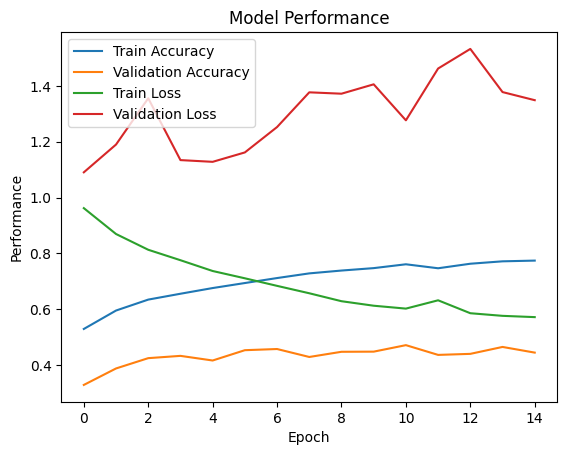

In [51]:
# Plot the history of accuracy and loss
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Performance')
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'Train Loss', 'Validation Loss'], loc='upper left')
plt.show()
